# Physics-informed neural network (PINN) demo


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os

## Task 1: train a PINN to simulate the system

#### Task

The first task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the boundary conditions of the system
- Outputs: estimate of the solution, $y(x)$

#### Differential Equation with B.C.

$$ \frac{d^2y}{dx^2} + y -x^2 = 0 $$

$$ y(0) = 0 $$

$$ y(1) = 0 $$





#### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
N\!N(x;\theta) \approx y(x)~,
$$


#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= \lambda_1(N\!N(0;\theta) - 0)^2 +  \frac{\lambda_2}{N} \sum^{N}_{i} \left( \frac{dN\!N(t_{i};\theta)}{dx} - x \right)^2
$$

#### Computing gradients

To compute gradients of the neural network with respect to its inputs, we will use `torch.autograd.grad`

## Initial setup

First, we define a few helper functions.

In [4]:
def exact_solution(x):
    u = ((1-2*np.cos(1))/np.sin(1))*np.sin(x) +2*np.cos(x)+x**2-2
    return u

class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

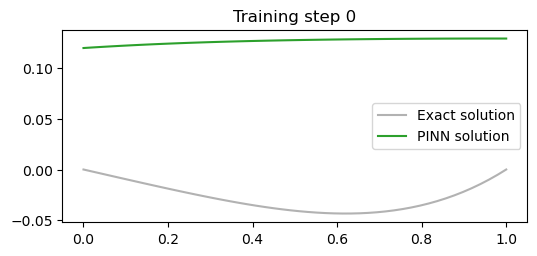

Epoch [1/6000], Loss: 0.1499
BC1 LOSS 0.01659518852829933
BC2 LOSS 0.019883761182427406
PDE LOSS 0.1345113217830658


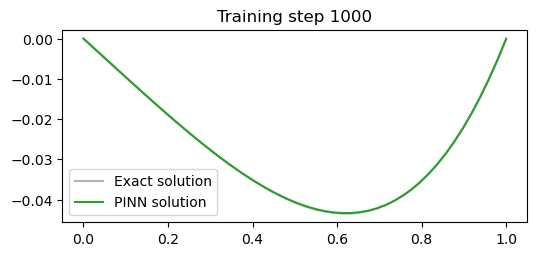

Epoch [1001/6000], Loss: 0.0001
BC1 LOSS 1.0261303806657907e-08
BC2 LOSS 3.761758904374801e-09
PDE LOSS 7.571379683213308e-05


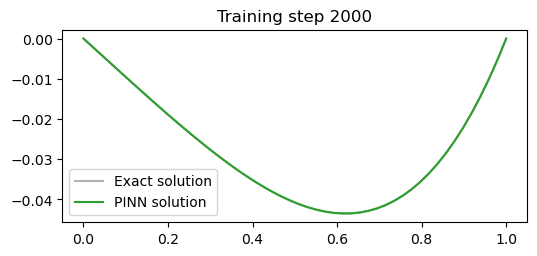

Epoch [2001/6000], Loss: 0.0000
BC1 LOSS 2.9518809618878095e-10
BC2 LOSS 9.381384558082573e-11
PDE LOSS 5.42330599273555e-06


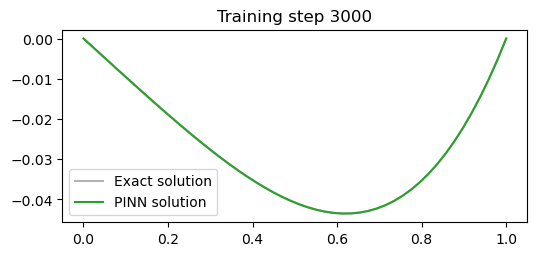

Epoch [3001/6000], Loss: 0.0000
BC1 LOSS 1.7037260491292727e-11
BC2 LOSS 6.23723295234413e-11
PDE LOSS 2.6601023819239344e-06


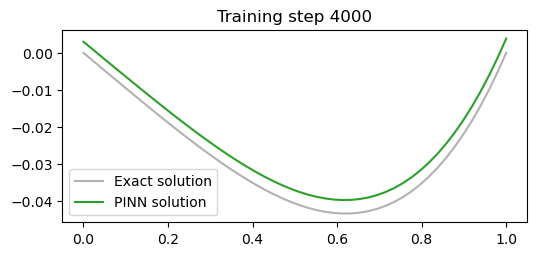

Epoch [4001/6000], Loss: 0.0000
BC1 LOSS 9.487565876042936e-06
BC2 LOSS 1.5789049939485267e-05
PDE LOSS 9.032326488522813e-06


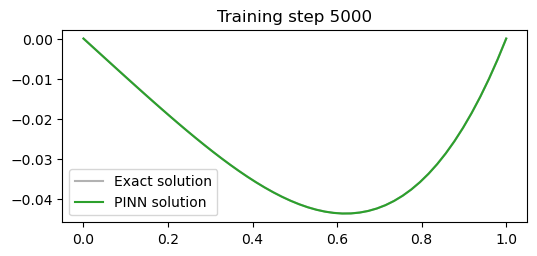

Epoch [5001/6000], Loss: 0.0000
BC1 LOSS 4.6373793693987864e-11
BC2 LOSS 8.86899442775757e-11
PDE LOSS 1.627502797418856e-06


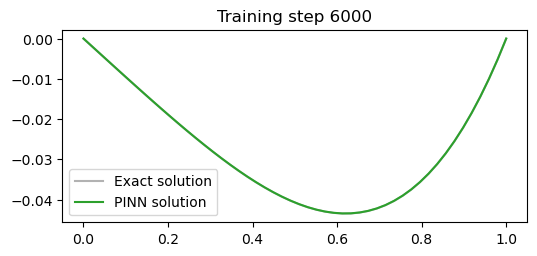

Epoch [6001/6000], Loss: 0.0000
BC1 LOSS 5.550140347310162e-10
BC2 LOSS 8.486600311385928e-10
PDE LOSS 1.395780259372259e-06


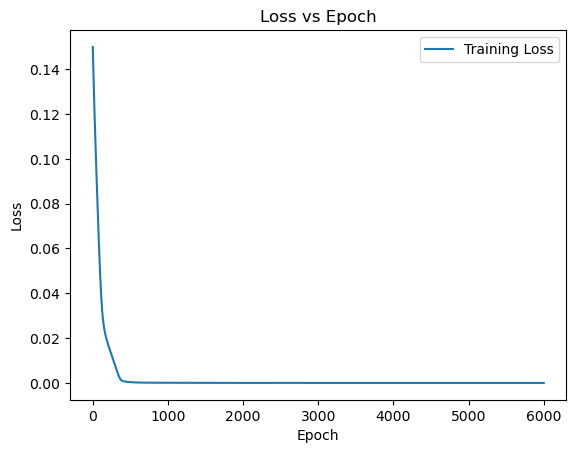

In [5]:
# define a neural network to train
pinn = FCN(1, 1, 64,3)

# define boundary points, for the boundary loss
x_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)# (1, 1)
x_boundary2 = torch.tensor(1.0).view(-1,1).requires_grad_(True)# (1, 1)

# define training points over the entire domain, for the physics loss
x_physics = torch.linspace(0, 1,200).view(-1,1).requires_grad_(True)# (20, 1)

x_test = torch.linspace(0,1,50).view(-1,1) #(200, 1)

u_exact = exact_solution(x_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-4)
num_epochs = 6000
losses = []
for i in range(num_epochs+1):
    optimiser.zero_grad()

    # using the following hyperparameters
    lambda1, lambda2 = 0.9, 0.7

    # compute boundary loss
    u = pinn(x_boundary)# (1, 1)
    loss1 = (torch.squeeze(u))**2

    u2 = pinn(x_boundary2)
    # dudx = torch.autograd.grad(u2, x_boundary2, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    # dudx2 = torch.autograd.grad(dudx, x_boundary2, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    loss2 = (torch.squeeze(u2))**2

    # compute physics loss
    u = pinn(x_physics)  # (20, 1)
    dudx = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    dudx2 = torch.autograd.grad(dudx, x_physics, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    loss3 = torch.mean((dudx2 + u -x_physics**2)**2)

    # backpropagate joint loss, take optimiser step
    loss = lambda1* loss1 + lambda2* loss2 + lambda1*loss3
    loss.backward()
    optimiser.step()
    losses.append(loss.item())

    # plot the result as training progresses
    if i % 1000 == 0:
        u = pinn(x_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.plot(x_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(x_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()
        print(f"Epoch [{i+1}/{num_epochs}], Loss: {loss.item():.4f}")
        print(f'BC1 LOSS {loss1}')
        print(f'BC2 LOSS {loss2}')
        print(f'PDE LOSS {loss3}')


plt.plot(range(1, num_epochs+2), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

Avg Percentage Error (excluding infinite values) is: 0.16604259610176086
Maximum Percentage Error (excluding infinite values) is: [--]


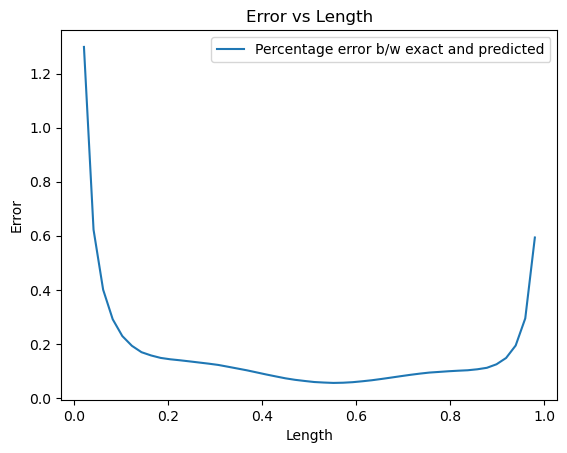

In [6]:
# Calculate error
diff = abs(u_exact - u) / abs(0.01 * u_exact)

# Mask out infinite values
masked_diff = np.ma.masked_invalid(diff)
max_error = max(masked_diff)

# Calculate mean excluding infinite values
mean_error = np.mean(masked_diff)

print(f'Avg Percentage Error (excluding infinite values) is: {mean_error}')
print(f'Maximum Percentage Error (excluding infinite values) is: {max_error}')

# Plot
plt.plot(x_test, diff, label='Percentage error b/w exact and predicted')
plt.xlabel('Length')
plt.ylabel('Error')
plt.title('Error vs Length')
plt.legend()
plt.show()


Overall RMSE is: 2.9378608815022744e-05


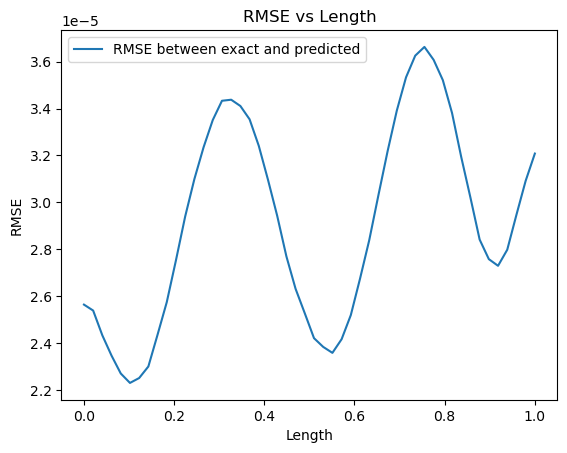

In [7]:
# Assuming u_exact and u are NumPy arrays
u_exact2 = u_exact.numpy()
u2 = u.numpy()

# Calculate RMSE at each point
rmse_per_point = np.sqrt(np.mean((u_exact2 - u2)**2, axis=1))
overall_rmse = np.sqrt(np.mean((u_exact2 - u2)**2))
print(f'Overall RMSE is: {overall_rmse}')

# Plot the RMSE at each point
plt.plot(x_test, rmse_per_point, label='RMSE between exact and predicted')
plt.xlabel('Length')
plt.ylabel('RMSE')
plt.title('RMSE vs Length')
plt.legend()
plt.show()


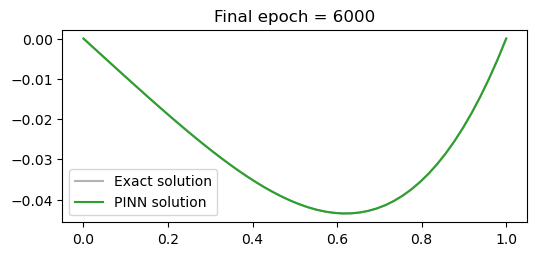

In [8]:
plt.figure(figsize=(6,2.5))
plt.plot(x_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.plot(x_test[:,0], u[:,0], label="PINN solution", color="tab:green")
plt.title(f"Final epoch = {i}")
plt.legend()
plt.show()

In [11]:
print(u[-2])
print(u_exact)

tensor([-0.0052])
tensor([[ 0.0000],
        [-0.0020],
        [-0.0039],
        [-0.0059],
        [-0.0078],
        [-0.0097],
        [-0.0117],
        [-0.0136],
        [-0.0155],
        [-0.0174],
        [-0.0193],
        [-0.0211],
        [-0.0229],
        [-0.0247],
        [-0.0264],
        [-0.0281],
        [-0.0298],
        [-0.0314],
        [-0.0329],
        [-0.0343],
        [-0.0357],
        [-0.0370],
        [-0.0382],
        [-0.0393],
        [-0.0403],
        [-0.0412],
        [-0.0419],
        [-0.0425],
        [-0.0430],
        [-0.0433],
        [-0.0435],
        [-0.0435],
        [-0.0433],
        [-0.0429],
        [-0.0422],
        [-0.0414],
        [-0.0404],
        [-0.0391],
        [-0.0375],
        [-0.0357],
        [-0.0336],
        [-0.0312],
        [-0.0285],
        [-0.0255],
        [-0.0222],
        [-0.0185],
        [-0.0144],
        [-0.0100],
        [-0.0052],
        [ 0.0000]])


In [19]:
print(len(u))
print((masked_diff))

50
[[--]
 [1.706000804901123]
 [0.8010034561157227]
 [0.4898308515548706]
 [0.33801838755607605]
 [0.2514490783214569]
 [0.2022826075553894]
 [0.17206382751464844]
 [0.15654662251472473]
 [0.14892065525054932]
 [0.14607900381088257]
 [0.1459241509437561]
 [0.14731614291667938]
 [0.148319810628891]
 [0.14890478551387787]
 [0.14793573319911957]
 [0.14515160024166107]
 [0.14146731793880463]
 [0.13602517545223236]
 [0.1291191577911377]
 [0.12109880894422531]
 [0.1128048449754715]
 [0.10411468148231506]
 [0.09585645794868469]
 [0.08813595771789551]
 [0.08137747645378113]
 [0.07581777125597]
 [0.07177990674972534]
 [0.06938344240188599]
 [0.06891030818223953]
 [0.07058662176132202]
 [0.07394644618034363]
 [0.0783633217215538]
 [0.08403495699167252]
 [0.09028887003660202]
 [0.09685726463794708]
 [0.10336039215326309]
 [0.10988365858793259]
 [0.11502507328987122]
 [0.11954692751169205]
 [0.12345854192972183]
 [0.12662743031978607]
 [0.1314774751663208]
 [0.13843846321105957]
 [0.15268823504447

In [12]:
print(u[99])

IndexError: index 99 is out of bounds for dimension 0 with size 50